## Import essential libraries

In [2]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import time
from collections import Counter

%matplotlib inline
plt.style.use('ggplot')

import miner as miner

## Define paths to data and results

In [3]:
#Select state or mutation ID to perform further analysis
anchor_id = 3

# Path to the miner directory
input_path = os.path.join(os.path.expanduser('~'),'Desktop','miner3','miner')
DATA_PATH = os.path.join(os.path.expanduser('~'),'Desktop','miner3','miner','gbm_data')

# create name for results folder where output files will be saved
resultsFolder = "state_clustering_results_3_14_2023"

# name of the folder containing the miner network
networkFolder = "MINER_All_ST052022"
NETWORK_PATH = os.path.join(os.path.expanduser('~'),'Desktop','miner3','miner',networkFolder)

# create results directory
resultsDirectory = os.path.join(input_path, resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load data

In [4]:
# Load expression Data
expressionFile = os.path.join(DATA_PATH, "expression",
                              "GbmMicroRNAMergedWithIDsZScored.csv")
mapfile = os.path.join(DATA_PATH, 'identifier_mappings.txt')
expressionData=pd.read_csv(expressionFile,header=0,index_col=0,sep=",")

# Load mutations
common_mutations_file = os.path.join(DATA_PATH,"mutations","mutations.GBM.TCGA.2019.05.01.csv")
mutation_matrix = pd.read_csv(common_mutations_file,index_col=0,header=0)
#mutation_matrix.index=[x.split('_')[0] for x in list(mutation_matrix.index)]

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(NETWORK_PATH,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(NETWORK_PATH,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(NETWORK_PATH,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(NETWORK_PATH,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(NETWORK_PATH,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(NETWORK_PATH,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(NETWORK_PATH,"underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(NETWORK_PATH,"eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

#Load table for converting gene names
id_table_path = os.path.join(DATA_PATH, 'identifier_mappings.txt')
id_table = pd.read_csv(id_table_path,sep="\t")
id_table = id_table[id_table["Source"] == "Gene Name"]
id_table.index = id_table.iloc[:,0]

## Format transcriptional program and states data for analysis

In [5]:

# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

states_df = pd.DataFrame(np.zeros((len(states),expressionData.shape[1])))
states_df.index = list(range(1,len(states)+1))
states_df.columns = expressionData.columns

for i in range(len(states)):
    states_df.loc[i+1,states[i]] = 1


state_labels = pd.DataFrame(np.zeros((expressionData.shape[1],1)))
state_labels.index = expressionData.columns
state_labels.columns = ["state"]
for j in range(states_df.shape[0]):
    s = states_df.index[j]
    state_labels.loc[states[j],"state"] = int(s)

state_labels.head()

,state
TCGA-06-0125.1,4.0
TCGA-06-0190.1,2.0
TCGA-28-2499,16.0
TCGA-06-0210.1,4.0
TCGA-06-AABW,19.0


In [6]:
# Create dictionary of program genes
# make dictionary of genes by program
pr_genes = {}
for i in range(len(program_list)):
    rgns = program_list[i]
    genes = []
    for r in rgns:
        genes.append(regulonModules[r])
    genes = list(set(np.hstack(genes)))
    pr_genes[i] = genes
    
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = pr_genes
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers_pr = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers_pr = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)

# write membership matrices to .csv file
overExpressedProgramsMatrix_pr = miner.membershipToIncidence(overExpressedMembers_pr,expressionData)
#overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedProgramsMatrix_pr = miner.membershipToIncidence(underExpressedMembers_pr,expressionData)
#underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))

# Generate program activity difference matrix
dfr_pr = overExpressedProgramsMatrix_pr - underExpressedProgramsMatrix_pr

## Perform causal analysis

In [7]:
# Define reference information for causal analysis
referenceDictionary = regulonModules
referenceRegulonDf = regulonDf
referenceDf = eigengenes
reference_patients = expressionData.columns

#Identify reference genotype or phenotype matrix as "mut_matrix"
#Using states_df is akin to differential expression analysis of states
#The causal results will show regulons that are perturbed in each state

mut_matrix = states_df.copy()
mut_matrix.index = np.array(mut_matrix.index).astype(str)

In [8]:
mut_matrix

,TCGA-06-0125.1,TCGA-06-0190.1,TCGA-28-2499,TCGA-06-0210.1,TCGA-06-AABW,TCGA-19-4065,TCGA-19-4065.1,TCGA-14-1034.1,TCGA-02-0055,TCGA-06-0211.1,...,TCGA-06-0876,TCGA-14-1827,TCGA-06-0208,TCGA-28-1752,TCGA-19-4068,TCGA-06-0673,TCGA-02-0432,TCGA-08-0520,TCGA-08-0521,TCGA-12-0826
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
from tqdm.notebook import tqdm, trange
import time
def causalNetworkAnalysis(regulon_matrix,expression_matrix,reference_matrix,mutation_matrix,resultsDirectory,minRegulons=1,significance_threshold=0.05,causalFolder="causal_results"):
    print("Creating directories if dont exist")
    if not os.path.isdir(resultsDirectory):
        os.mkdir(resultsDirectory)    
    # create results directory
    causal_path = os.path.join(resultsDirectory,causalFolder)
    if not os.path.isdir(causal_path):
        os.mkdir(causal_path)

    t1 = time.time()
    
    ###
    regulon_df_bcindex = regulon_matrix.copy()
    regulon_df_bcindex.index = np.array(regulon_df_bcindex["Regulon_ID"]).astype(str)

    regulon_df_gene_index = regulon_matrix.copy()
    regulon_df_gene_index.index = regulon_df_gene_index["Gene"]

    tf_name = []
    bc_name = []
    rs_1 = []
    ps_1 = []
    index_1 = []
    
    print("Testing correlation of TF and cluster eigengene.")
    # Test correlation of TF and cluster eigengene
    missing_tfs = list(set(regulon_df_bcindex.loc[:,"Regulator"])-set(expression_matrix.index))
    for key in list(set(regulon_df_bcindex.index)):
        e_gene = reference_matrix.loc[str(key),:]
        tf = list(regulon_df_bcindex.loc[key,"Regulator"])[0]
        if tf not in missing_tfs:
            tf_exp = expression_matrix.loc[tf,reference_matrix.columns]
            r, p = stats.spearmanr(tf_exp, e_gene)
        else:
            r, p = (0,1)
        tf_name.append(tf)
        bc_name.append(key)
        rs_1.append(r)
        ps_1.append(p)
        index_1.append(key)

    correlation_df_bcindex = pd.DataFrame(np.vstack([tf_name,bc_name,rs_1,ps_1]).T) # Table
    correlation_df_bcindex.columns = ["Regulator","Regulon_ID","Spearman_R","Spearman_p"]
    correlation_df_bcindex.index = np.array(index_1).astype(str)

    correlation_df_regulator_index = correlation_df_bcindex.copy() # Table
    correlation_df_regulator_index.index = correlation_df_regulator_index["Regulator"]

    print("Looping through each mutation")
    ###
    for mut_ix in tqdm(range(mutation_matrix.shape[0])):
        time.sleep(0.01)
        mutation_name = mutation_matrix.index[mut_ix]

        phenotype_2 = mutation_matrix.columns[mutation_matrix.loc[mutation_name,:]==1]
        phenotype_1 = list(set(mutation_matrix.columns)-set(phenotype_2))
        phenotype_2 = list(set(phenotype_2)&set(reference_matrix.columns))
        phenotype_1 = list(set(phenotype_1)&set(reference_matrix.columns))
        
        # Welch's t-test of cluster eigengene versus mutation status
        regulon_ttests = pd.DataFrame(
            np.vstack(
                stats.ttest_ind(reference_matrix.loc[:,phenotype_2],reference_matrix.loc[:,phenotype_1],equal_var=False,axis=1)
            ).T
        )

        regulon_ttests.index = reference_matrix.index
        regulon_ttests.columns = ["Regulon_t-test_t","Regulon_t-test_p"] # Table1: eigengenes ttests

        result_dfs = []
        mean_ts = []
        mean_significance = []

        # Identify TFs that are regulators of clusters, but not members of any clusters
        upstream_regulators = list(set(regulon_matrix.Regulator)-set(regulon_df_gene_index.index))
        
        # Iterate over regulators that are also members of clusters
        for regulator_ in list(set(regulon_matrix.Regulator)):  # analyze all regulators (may be or not be members in cluster), modified by YH 10/07/2022
            xt, xp = stats.ttest_ind(expression_matrix.loc[regulator_,phenotype_2],expression_matrix.loc[regulator_,phenotype_1],equal_var=False)
            mean_ts = xt
            mean_significance = -np.log10(xp)
            
            if mean_significance >= -np.log10(significance_threshold):
                downstream_tmp = correlation_df_regulator_index.loc[regulator_,"Regulon_ID"]
                if type(downstream_tmp) is not pd.core.series.Series:
                    downstream_regulons = [str(downstream_tmp)]
                elif type(downstream_tmp) is pd.core.series.Series:
                    downstream_regulons = list(np.array(downstream_tmp).astype(str))

                if len(downstream_regulons)<minRegulons:
                    continue

                d_neglogps = []
                d_ts = []
                # Check for significant difference in expression of clusters regulated BY the regulator
                for downstream_regulon_ in downstream_regulons:
                    dt, dp = list(regulon_ttests.loc[downstream_regulon_,:])
                    tmp_neglogp = -np.log10(dp)
                    d_neglogps.append(tmp_neglogp)
                    d_ts.append(dt)

                d_neglogps = np.array(d_neglogps)
                d_ts = np.array(d_ts)

                mask = np.where(d_neglogps >= -np.log10(significance_threshold))[0]
                if len(mask) == 0:
                    continue

                # Significance of differential cluster expression in target clusters of regulator
                significant_regulons = np.array(downstream_regulons)[mask]
                significant_regulon_ts = d_ts[mask]
                significant_regulon_ps = d_neglogps[mask]

                # Significance of tf-cluster correlation for downstream clusters
                significant_Rs = np.array(correlation_df_bcindex.loc[significant_regulons,"Spearman_R"]).astype(float)
                significant_ps = np.array(correlation_df_bcindex.loc[significant_regulons,"Spearman_p"]).astype(float)

                # (mean_ts = mean t-statistic of mutation-regulator edge)*(array of corr. coeff. of tf-cluster edges)*(array of t-statistics for downstream regulon diff. exp. in WT vs mutant)
                assignment_values = mean_ts*significant_Rs*significant_regulon_ts
                #assignments = assignment_values/np.abs(assignment_values)
                alignment_mask = np.where(assignment_values>0)[0]

                if len(alignment_mask) == 0:
                    continue

                mutation_list = np.array([mutation_name for i in range(len(alignment_mask))])
                regulator_list = np.array([regulator_ for i in range(len(alignment_mask))])
                bicluster_list = significant_regulons[alignment_mask]
                mutation_regulator_edge_direction = np.array([mean_ts/np.abs(mean_ts) for i in range(len(alignment_mask))])
                mutation_regulator_edge_ps = np.array([mean_significance for i in range(len(alignment_mask))])
                regulator_bicluster_rs = significant_Rs[alignment_mask]
                regulator_bicluster_ps = significant_ps[alignment_mask]    
                bicluster_ts = significant_regulon_ts[alignment_mask]
                bicluster_ps = significant_regulon_ps[alignment_mask]  
                fraction_aligned = np.array([len(alignment_mask)/float(len(mask)) for i in range(len(alignment_mask))])
                fraction_effected = np.array([len(alignment_mask)/float(len(d_neglogps)) for i in range(len(alignment_mask))]) #New addition
                n_downstream = np.array([len(d_neglogps) for i in range(len(alignment_mask))])
                n_diff_exp = np.array([len(mask)for i in range(len(alignment_mask))])

                #if regulator_=='ENSG00000010030' and mutation_name=='IDH1_code_potential_somatic':
                #    print(mutation_name,regulator_,xt,xp,significant_regulons,bicluster_list)
                
                results_ = pd.DataFrame(
                    np.vstack(
                        [
                            mutation_list,
                            regulator_list,
                            bicluster_list,
                            mutation_regulator_edge_direction,
                            mutation_regulator_edge_ps,
                            regulator_bicluster_rs,
                            regulator_bicluster_ps,
                            bicluster_ts,
                            bicluster_ps,
                            fraction_aligned,
                            fraction_effected,
                            n_downstream,
                            n_diff_exp
                        ]
                    ).T
                )

                results_.columns = [
                    "Mutation",
                    "Regulator",
                    "Regulon",
                    "MutationRegulatorEdge",
                    "-log10(p)_MutationRegulatorEdge",
                    "RegulatorRegulon_Spearman_R",
                    "RegulatorRegulon_Spearman_p-value",
                    "Regulon_stratification_t-statistic",
                    "-log10(p)_Regulon_stratification",
                    "Fraction_of_edges_correctly_aligned",
                    "Fraction_of_aligned_and_diff_exp_edges",
                    "number_downstream_regulons",
                    "number_differentially_expressed_regulons"#New addition
                ]

                results_.index = bicluster_list

                result_dfs.append(results_)

            elif mean_significance < -np.log10(significance_threshold):
                continue

        if len(result_dfs) == 0:
            continue
        elif len(result_dfs) == 1:
            causal_output = result_dfs[0]
        if len(result_dfs) > 1:
            causal_output = pd.concat(result_dfs,axis=0)
            
        output_file = ("").join([mutation_name,"_causal_results",".csv"])
        causal_output.to_csv(os.path.join(causal_path,output_file))


    t2 = time.time()

    print('completed causal analysis in {:.2f} minutes'.format((t2-t1)/60.))
    
    return

In [10]:
#Perform causal analysis using mut_matrix for anchors
causal_results_directory = os.path.join(resultsDirectory,"causal_analysis")
causal_subdirectory = "causal_results"
causalNetworkAnalysis
causal_states = causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),
                                            expression_matrix=expressionData.copy(),
                                            reference_matrix=referenceDf.copy(),
                                            mutation_matrix=mut_matrix,
                                            resultsDirectory=causal_results_directory,
                                            minRegulons=1,significance_threshold=0.05,
                                            causalFolder=causal_subdirectory)


Creating directories if dont exist
Testing correlation of TF and cluster eigengene.
Looping through each mutation


  0%|          | 0/23 [00:00<?, ?it/s]

completed causal analysis in 0.28 minutes


In [11]:
# compile all causal results
# If states_df was passed as mut_matrix, the state is under the "Mutation" heading
causal_states_directory = os.path.join(causal_results_directory,causal_subdirectory)
causal_states = miner.readCausalFiles(causal_states_directory)
causal_states.to_csv(os.path.join(resultsDirectory,"CausalStatesResults.csv"))
print(causal_states.shape)
causal_states.head()

(21562, 13)


,Mutation,Regulator,Regulon,MutationRegulatorEdge,-log10(p)_MutationRegulatorEdge,RegulatorRegulon_Spearman_R,RegulatorRegulon_Spearman_p-value,Regulon_stratification_t-statistic,-log10(p)_Regulon_stratification,Fraction_of_edges_correctly_aligned,Fraction_of_aligned_and_diff_exp_edges,number_downstream_regulons,number_differentially_expressed_regulons
2058,13,ENSG00000124766,R-2058,1.0,2.147679,0.307194,1.932955e-13,2.719256,1.486727,1.0,0.266667,15,4
2063,13,ENSG00000124766,R-2063,1.0,2.147679,0.659712,9.458718e-70,3.132083,1.721773,1.0,0.266667,15,4
2057,13,ENSG00000124766,R-2057,1.0,2.147679,0.287724,6.612808e-12,2.601435,1.411102,1.0,0.266667,15,4
2052,13,ENSG00000124766,R-2052,1.0,2.147679,0.748827,1.319733e-99,3.953140,2.189678,1.0,0.266667,15,4
326,13,ENSG00000120690,R-326,1.0,1.488551,0.583223,2.981852e-51,2.762216,1.570582,0.5,0.041667,24,2


## Load databases for TF-TF network inference

In [12]:
#Index network dataframe with regulon id
regulonDf_regid = regulonDf.copy()
regulonDf_regid.index = regulonDf_regid.Regulon_ID

#Load reference TFBSDB database oriented from targets to tfs
tfbsdb_genes_to_tf = miner.read_pkl(os.path.join(input_path,"data","network_dictionaries","tfbsdb_genes_to_tf.pkl"))

#Load reference chip-seq database
chea_genes_to_tf = miner.read_pkl(os.path.join(input_path,"data","network_dictionaries","chea_reciprocal.pkl"))

## Filter causal results to generate high-confidence network

In [13]:
#Select state or mutation ID to perform further analysis
#anchor_id = 3

#Subset causal results to anchor_id
causal_subset = causal_states.iloc[np.where(causal_states.Mutation==anchor_id)[0],:]

#Filter causal results to generate high-confidence network
#The "Fraction_of_aligned_and_diff_exp_edges" parameter controls which regulons are kept
#If a regulator is differentially expressed, and its targeted regulons are differentially
#expressed in the direction consistent with the regulator-target regulon edge, a causal link
#is drawn from the state or mutation to the regulator and regulons. We do not require that
#every regulon downstream of a regulator is differentially expressed. The proportion that
#must be differentially expressed is defined by the "Fraction_of_aligned_and_diff_exp_edges" parameter. 

#Apply default parameter of 0.5, or customize between [0,1] (1 is most stringent)
fraction_of_impacted_regulons = 0.5
causal_subset = causal_subset.iloc[np.where(causal_subset.Fraction_of_aligned_and_diff_exp_edges>fraction_of_impacted_regulons)[0],:]
causal_subset.sort_values(by="Fraction_of_aligned_and_diff_exp_edges",ascending=False,inplace=True)

#Separate TFs that are activated or repressed in causal subset
mut_act = causal_subset[causal_subset.MutationRegulatorEdge==1].Regulator.unique()
mut_rep = causal_subset[causal_subset.MutationRegulatorEdge==-1].Regulator.unique()

print("{:d} causal flows specific to subset".format(causal_subset.shape[0]))

2426 causal flows specific to subset


## List regulators specific to causal subset

In [14]:
#List regulators specific to causal subset
from collections import Counter
regulator_count = Counter(causal_subset.Regulator)
reglist = [g[0] for g in regulator_count.most_common()]
regulator_count.most_common()[0:10]

[('ENSG00000126456', 25),
 ('ENSG00000187140', 25),
 ('ENSG00000168610', 25),
 ('ENSG00000204103', 25),
 ('ENSG00000167034', 25),
 ('ENSG00000107187', 24),
 ('ENSG00000115297', 24),
 ('ENSG00000125347', 24),
 ('ENSG00000177606', 24),
 ('ENSG00000176678', 24)]

## Define output directory for TF-TF network inference

In [15]:
#Create results directory
if not os.path.isdir(os.path.join(resultsDirectory,str(anchor_id))):
    os.mkdir(os.path.join(resultsDirectory,str(anchor_id)))
tf_network_directory = os.path.join(resultsDirectory,str(anchor_id),"tf-epi_network")

if not os.path.isdir(tf_network_directory):
    os.mkdir(tf_network_directory)

## Predict TF-TF network

In [16]:
def setdiff(x,y):
    return list(set(x)-set(y))

def sample(x,n,replace=True):
    from numpy.random import choice
    return choice(x,n,replace=replace)

def train_test(x,y,names=None):

    # identify class labels
    class_0 = np.where(y<=0)[0]
    class_1 = np.where(y>0)[0]

    # define class lengths
    n_class_0 = len(class_0)
    n_class_1 = len(class_1)

    # bootstrap class labels
    bootstrap_train_0 = list(set(sample(class_0,n_class_0,replace = True)))
    bootstrap_test_0 = setdiff(class_0,bootstrap_train_0)
    if len(bootstrap_test_0) == 0:
        bootstrap_train_0 = list(set(sample(class_0,n_class_0,replace = True)))
        bootstrap_test_0 = setdiff(class_0,bootstrap_train_0)        
    
    bootstrap_train_1 = list(set(sample(class_1,n_class_1,replace = True)))
    bootstrap_test_1 = setdiff(class_1,bootstrap_train_1)
    if len(bootstrap_test_1) == 0:
        bootstrap_train_1 = list(set(sample(class_1,n_class_1,replace = True)))
        bootstrap_test_1 = setdiff(class_1,bootstrap_train_1)
        
    # prepare bootstrap training and test sets
    train_rows = np.hstack([bootstrap_train_0,
                    bootstrap_train_1])

    test_rows = np.hstack([bootstrap_test_0,
                   bootstrap_test_1])

    x_train = x[:,train_rows]
    x_test = x[:,test_rows]
    y_train = y[train_rows]
    y_test = y[test_rows]

    if names is None:
        split = {"x_train":x_train,
                 "x_test":x_test,
                 "y_train":y_train,
                 "y_test":y_test
                }

    elif names is not None:
        train_names = np.array(names)[train_rows]
        test_names = np.array(names)[test_rows]
        split = {"x_train":x_train,
                 "x_test":x_test,
                 "y_train":y_train,
                 "y_test":y_test,
                 "names_train":train_names,
                 "names_test":test_names
                }
        
    return split

def gene_conversion(gene_list,input_type="ensembl.gene", output_type="symbol",list_symbols=None,id_table=None):

    if input_type =="ensembl":
        input_type = "ensembl.gene"
    if output_type =="ensembl":
        output_type = "ensembl.gene"
    #kwargs = symbol,ensembl, entrezgene
    
    if id_table is None:
        import mygene #requires pip install beyond anaconda
        mg = mygene.MyGeneInfo()
        gene_query = mg.querymany(gene_list, scopes=input_type, fields=[output_type], species="human", as_dataframe=True)
    
        if list_symbols is not None:
            if output_type == "ensembl.gene":
                list_ = list(gene_query[output_type])
                #print(list_)
                output = []
                for dict_ in list_:
                    if type(dict_) is dict:
                        output.append(dict_["gene"])
                    else:
                        for subdict in dict_:
                            output.append(subdict["gene"])
            else:
                output = list(gene_query[output_type])
            return output
        
        dict_ = {}
        try:
            trimmed_df = gene_query[gene_query.iloc[:,2]>0]
            for i in range(0,trimmed_df.shape[0]):
                tmp = trimmed_df.index[i]
                tmp1 = trimmed_df.iloc[i,2]
                dict_[tmp] = []
                lencheck = len(tmp1)
                if lencheck == 1:
                    dict_[tmp].append(str(tmp1).split("'")[3])
                if lencheck > 1:
                    for j in range(0,len(tmp1)):            
                        dict_[tmp].append(str(tmp1[j]).split("'")[3])
        except:
            return gene_query
        
        return dict_
    
    if input_type == "ensembl.gene":
        conv_ = id_table.loc[gene_list,"Name"]
    
    if input_type == "symbol":
        tmp_table = id_table.copy()
        tmp_table.index = list(id_table.loc[:,"Name"])
        conv_ = tmp_table.loc[gene_list,"Preferred_Name"]
        del tmp_table       
    
    if list_symbols is True:
        if type(conv_)==pd.core.series.Series:
            conv_ = list(conv_)
        else:
            conv_ = [conv_]
    
    return conv_

def get_downstream_tfs(tf,tf_network_ensembl):
    '''Create dictionary of TF keys and target tf elements'''
    tmp_df = tf_network_ensembl[tf_network_ensembl.Source==tf]
    tmp_act_tf = list(tmp_df[tmp_df.Edge==1].Target)
    tmp_rep_tf = list(tmp_df[tmp_df.Edge==-1].Target)
    return {"activated":tmp_act_tf,"repressed":tmp_rep_tf}

In [17]:
# Predict expression of each TF in network from other TFs in network
# Require that predictor TFs have binding site for target TF
# Supply TFBSDB and CHiP-seq database information for binding sites

from sklearn.linear_model import Lasso
import warnings

#Suppress warnings
warnings.filterwarnings("ignore")

#Set parameters for LASSO model
lambda_min = 0.1
n_iter = 50
reference_database = tfbsdb_genes_to_tf
reference_database2 = chea_genes_to_tf

#Create list to collect predictive performance measures
predictive_performance = []
for tf_ix in range(len(reglist)):
    #Identify TFs with binding sites in target TF promoter
    tf = reglist[tf_ix]
    
    matches = []
    if tf in reference_database.keys():
        matches = reference_database[tf]
 
    matches_2 = []
    if reference_database2 is not None:
        if tf in reference_database2.keys():
            matches_2 = reference_database2[tf]
        
    matches = list(set(matches)|set(matches_2))    
    hits = miner.intersect(reglist,matches)

    #Remove target TF from predictors
    hits = miner.setdiff(hits,[tf])
    if len(hits) == 0:
        print(tf+" has no upstream tfs")
        continue

    #Loop over coefficient thresholds to identify optimal model
    mean_rs = []
    mean_coefs = []
    hitlist = []
    hitlist.append(hits)
    for threshold in np.arange(0.01,0.21,0.01):
        #Generate matrices for TF-TF network inferences
        if len(hits)>0:
            tmp_x = np.array(expressionData.loc[hits,reference_patients])
            tmp_y = np.array(expressionData.loc[tf,reference_patients])

        # Perform n_iter bootstrap iterations of predicting TF expression
        coefs = []
        rs = []
        for iter in range(n_iter):
            #Split data into training and test sets
            train_test_dict = train_test(tmp_x,tmp_y,reference_patients)
            X = train_test_dict["x_train"].T
            y = train_test_dict["y_train"]

            #Generate LASSO model to predict TF expression
            clf = Lasso(random_state=0,alpha=lambda_min,fit_intercept=True)
            clf.fit(X, y) 

            #Retrieve model coefficients for weight of each TF in predicting target TF
            coef = clf.coef_
            coefs.append(coef)

            #Evaluate performace of predictor
            y_ = train_test_dict["y_test"]
            decision_function_score = clf.predict(train_test_dict["x_test"].T)
            r, p = stats.spearmanr(decision_function_score,train_test_dict["y_test"])
            rs.append(r)

        #Use the mean coefficient of all bootstrap runs for the final TF coefficients
        mean_coef = np.mean(np.vstack(coefs),axis=0)
        mean_coefs.append(mean_coef)

        #Use the mean correlation coefficient as the final performace metric
        mean_r = np.mean(np.vstack(rs),axis=0)
        #print("Mean Spearman correlation of model to target expression: {:.3f}".format(mean_r[0]))
        mean_rs.append(mean_r)

        #Restrict hits by thresholding coefficients for the next iteration
        hits = np.array(hits)[np.abs(mean_coef)>threshold]
        hitlist.append(hits)

        if len(hits) == 0:
            break

    #Set cut-off model performance
    #This makes the model as sparse as possible while maintaing
    #performance > thresh
    thresh = 0.975*mean_rs[0]

    #Identify optimal model
    filter_ = np.where(mean_rs<thresh)[0]
    if len(filter_) > 0:
        selection = np.where(mean_rs<thresh)[0][0]-1
    
    elif len(filter_)==0:
        selection = len(mean_rs)-1

    #Convert the ensembl ids to hgnc
    tf_names = gene_conversion(hitlist[selection],id_table=id_table,list_symbols=True)
    target_name = gene_conversion(tf,id_table=id_table,list_symbols=True)

    #List number of coefficients in each model
    len_coefs = [len(c) for c in mean_coefs]

    #Define output directory to save optimized model
    output_dir = os.path.join(tf_network_directory,target_name[0])
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    #Write model to file
    tmp_output = pd.DataFrame(mean_coefs[selection])
    tmp_output.columns = ["Coefficient"]
    tmp_output.index = tf_names
    tmp_output.to_csv(os.path.join(output_dir,"model.csv"))
    
    predictive_performance.append(mean_rs[selection][0])
    print("completed ",target_name[0]," model")

completed  IRF3  model
completed  FOXD3  model
completed  STAT3  model
completed  MAFB  model
completed  NKX3-1  model
completed  LHX3  model
completed  TLX2  model
completed  IRF1  model
completed  JUN  model
completed  FOXL1  model
completed  SPI1  model
completed  POU3F1  model
completed  CEBPG  model
completed  BARX1  model
completed  MEF2A  model
completed  NFKB1  model
completed  MTF1  model
completed  BCL6  model
completed  ZFX  model
completed  FOXJ3  model
completed  CEBPB  model
completed  IRF2  model
completed  SMAD1  model
completed  NR3C1  model
completed  STAT1  model
completed  CEBPA  model
completed  HOXA3  model
completed  ELF1  model
completed  YY1  model
completed  SOX1  model
completed  FOXC1  model
completed  NKX6-1  model
completed  EGR1  model
completed  PRDM1  model
completed  FOXO1  model
completed  STAT5A  model
completed  ZNF281  model
completed  FOXO3  model
completed  ALX4  model
completed  ELF4  model
completed  NRF1  model
completed  LEF1  model
completed

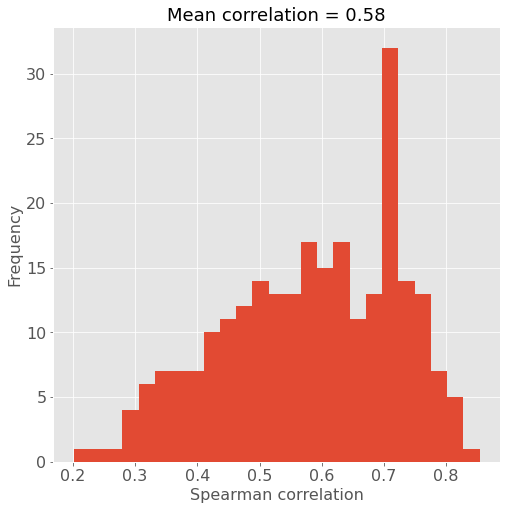

In [18]:
#Save histogram of predictive performace
plt.figure(figsize=(8,8))
plt.hist(predictive_performance,bins=25)
plt.ylabel("Frequency",fontsize=16)
plt.xlabel("Spearman correlation",fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title("Mean correlation = {:.2f}".format(np.nanmean(predictive_performance)),
         fontsize=18)
plt.savefig(os.path.join(tf_network_directory,"predictive_performace.pdf"),bbox_inches="tight")

## Compile tf-tf network from individual models

In [19]:
#List filenames from tf_network_directory
filenames = [x[0] for x in os.walk(tf_network_directory)]

#Read predictive models for each TF in network
lines = []
for filename in filenames[1:]:
    target = os.path.basename(os.path.normpath(filename))
    if target == 'epi-tf_network':
        continue
    if target == 'tf-tf_network':
        continue
    if target == os.path.basename(os.path.normpath(tf_network_directory)):
        continue
    
    model_df = pd.read_csv(os.path.join(filename,"model.csv"),index_col=0,header=0)
    
    for ix in model_df.index:
        tmp = [ix,model_df.loc[ix,"Coefficient"],target]
        lines.append(tmp)

#Write edges into a TF network
tf_network = pd.DataFrame(np.vstack(lines))
tf_network.columns = ["Source","Edge","Target"]
tf_network = tf_network[np.abs(np.array(tf_network.Edge).astype(float))>0.0]
tf_network.to_csv(os.path.join(tf_network_directory,"tf_tf_network.csv"))
tf_network.head()

,Source,Edge,Target
0,ESR1,0.1664916722475882,NR1H4
1,LMO2,-0.0874236099971144,NR1H4
2,FOS,-0.1120034448326174,NR1H4
3,LHX3,0.1200111289311896,NR1H4
4,ELF3,0.0841286603745656,HNF1A


In [20]:
len(set(tf_network['Source']))

234

## Calculate network parameters for each TF

In [21]:
#Create Table of in- and out-degrees
out_degree = []
in_degree = []

for tf in tf_network.Target.unique():
    tmp_in = sum(1*(tf_network.Target==tf))
    tmp_out = sum(1*(tf_network.Source==tf))
    out_degree.append(tmp_out)
    in_degree.append(tmp_in)
    
#Calculate ratio of out-degree to in-degree
out_over_in = list(np.array(out_degree)/np.array(in_degree).astype(float))

#Format information as dataframe
network_degrees = pd.DataFrame(np.vstack([in_degree,out_degree,out_over_in]).T)
network_degrees.columns = ["in_degree","out_degree","out/in"]
network_degrees.index = tf_network.Target.unique()
network_degrees.sort_values(by="out/in",ascending=False,inplace=True)

#Reconvert index to ensembl
ensembl_index = gene_conversion(network_degrees.index,
                      input_type="symbol",
                      output_type="ensembl.gene",
                      id_table=id_table,
                      list_symbols=True)

#Format ensembl index for integration
alt_id = pd.DataFrame(ensembl_index)
alt_id.columns = ["Alt_ID"]
alt_id.index = network_degrees.index

#Append ensembl index to network output
network_degrees = pd.concat([alt_id,network_degrees],axis=1)
network_degrees.to_csv(os.path.join(tf_network_directory,"tf_tf_network_degrees.csv"))

#Write to file
network_degrees.head()

,Alt_ID,in_degree,out_degree,out/in
ELF3,ENSG00000163435,2.0,16.0,8.000000
BPTF,ENSG00000171634,3.0,23.0,7.666667
MTF1,ENSG00000188786,4.0,24.0,6.000000
SOX9,ENSG00000125398,5.0,27.0,5.400000
ZNF281,ENSG00000162702,5.0,21.0,4.200000


In [22]:
network_degrees.sort_values(by='in_degree',ascending=False,inplace=False)

,Alt_ID,in_degree,out_degree,out/in
TBX21,ENSG00000073861,21.0,3.0,0.142857
HOXB9,ENSG00000170689,20.0,2.0,0.100000
ZNF263,ENSG00000006194,17.0,9.0,0.529412
GLI3,ENSG00000106571,16.0,0.0,0.000000
STAT4,ENSG00000138378,16.0,9.0,0.562500
...,...,...,...,...
HSF2,ENSG00000025156,2.0,3.0,1.500000
HOXD13,ENSG00000128714,2.0,2.0,1.000000
ELF3,ENSG00000163435,2.0,16.0,8.000000
ZIC3,ENSG00000156925,1.0,2.0,2.000000


In [23]:
network_degrees.sort_values(by='out_degree',ascending=False,inplace=False)

,Alt_ID,in_degree,out_degree,out/in
MEF2A,ENSG00000068305,10.0,29.0,2.900000
IRF2,ENSG00000168310,7.0,28.0,4.000000
SOX9,ENSG00000125398,5.0,27.0,5.400000
STAT3,ENSG00000168610,10.0,25.0,2.500000
RUNX1,ENSG00000159216,9.0,24.0,2.666667
...,...,...,...,...
PAX9,ENSG00000198807,6.0,0.0,0.000000
LMX1B,ENSG00000136944,2.0,0.0,0.000000
NR1H4,ENSG00000012504,4.0,0.0,0.000000
ETV2,ENSG00000105672,5.0,0.0,0.000000


## Probe TFs in TF-TF network

In [24]:
#Investigate regulators of a specific TF in the TF-TF network
myc_upstream = tf_network[tf_network.Target=="MYC"]
print(myc_upstream)

#Investigate targets of a specific TF in the TF-TF network
myc_downstream = tf_network[tf_network.Source=="MYC"]
print("\n",myc_downstream)

Empty DataFrame
Columns: [Source, Edge, Target]
Index: []

 Empty DataFrame
Columns: [Source, Edge, Target]
Index: []


## Draw TF network

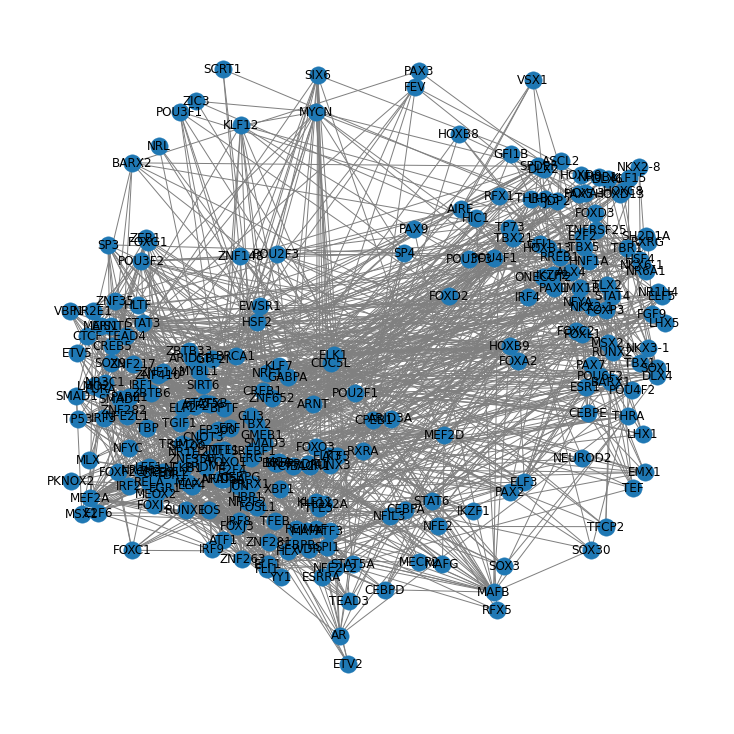

In [25]:
import networkx as nx

# instantiate graph and add edge information
G = nx.Graph()
elist = []
for i in range(tf_network.shape[0]):
    src = tf_network.iloc[i,0]
    tgt = tf_network.iloc[i,-1]
    edg = tf_network.iloc[i,1]
    elist.append((src,tgt,edg))
    
# create graph
G.add_weighted_edges_from(elist)

#Get positions of nodes
positions = nx.spring_layout(G)

#Plot network
plt.figure(figsize=(10,10))
nx.draw(G,positions,with_labels=True,edge_color = 'gray')

## Generate initial TF-target tfs dictionary for master regulator analysis

In [26]:
#Reconvert index to ensembl
ensembl_source = gene_conversion(list(tf_network.Source),
                      input_type="symbol",
                      output_type="ensembl.gene",
                      id_table=id_table,
                      list_symbols=True)

#Format for integration
alt_source = pd.DataFrame(ensembl_source)
alt_source.columns = ["Source"]
alt_source.index = tf_network.index

#Reconvert index to ensembl
ensembl_target = gene_conversion(list(tf_network.Target),
                      input_type="symbol",
                      output_type="ensembl.gene",
                      id_table=id_table,
                      list_symbols=True)

#Format for integration
alt_target = pd.DataFrame(ensembl_target)
alt_target.columns = ["Target"]
alt_target.index = tf_network.index

#Binarize edges
bin_edges = [1 if edge>0 else -1 for edge in np.array(tf_network.Edge).astype(float)]

#Format for integration
alt_edge = pd.DataFrame(bin_edges)
alt_edge.columns = ["Edge"]
alt_edge.index = tf_network.index

#Append to network output
tf_network_ensembl = pd.concat([alt_source,alt_edge,alt_target],axis=1)

#Create dictionary with TF as keys and direct targets as elements
tf_tf_dictionary = {tf:get_downstream_tfs(tf,tf_network_ensembl) for tf in reglist}

## Generate expanded TF-target tfs dictionary for master regulator analysis

In [27]:
def downstream_tf_analysis(regulators,tf_network,causal_subset):
    '''Create dictionary of TF keys and target tf elements, restricted to 
    align with causal perturbation of target tfs.'''
    #Generate dictionary of primary downstream tfs
    tf_tf_dictionary = {tf:get_downstream_tfs(tf,tf_network) for tf in regulators}
    
    #Separate tfs that are activated from those that are repressed in the causal subset
    mut_act = causal_subset[causal_subset.MutationRegulatorEdge==1].Regulator.unique()
    mut_rep = causal_subset[causal_subset.MutationRegulatorEdge==-1].Regulator.unique()

    aligned_tfs = {}
    #Create dictionary of primary downstream tfs that match causal subset direction
    for tf in mut_act:
        tmp_act_tfs = intersect(mut_act,tf_tf_dictionary[tf]["activated"])
        tmp_rep_tfs = intersect(mut_rep,tf_tf_dictionary[tf]["repressed"])
        aligned_tfs[tf] = union(tmp_act_tfs,tmp_rep_tfs)
        
    for tf in mut_rep:
        tmp_act_tfs = intersect(mut_rep,tf_tf_dictionary[tf]["activated"])
        tmp_rep_tfs = intersect(mut_act,tf_tf_dictionary[tf]["repressed"])
        aligned_tfs[tf] = union(tmp_act_tfs,tmp_rep_tfs)
        
    return aligned_tfs

def intersect(x,y):
    return list(set(x)&set(y))

def union(x,y):
    return list(set(x)|set(y))

def propagate_network(regulators,aligned_tfs_primary,n_propagate=2):
    '''Create dictionary of TF keys and aligned target tf elements.
    n-propagate sets the number of steps to propagate from TF source
    when collecting targets. If n_propagate=2, the direct targets of
    a TF, and the direct targets of each of the TF's direct targets
    are included in the dictionary. coverage_dict is the TF-targets
    dictionary. span_dict is the number of propagation steps needed to
    reach every tf in the network (only useful if n_propagate>2).'''
    
    import time
    t1 = time.time()

    span_dict = {}
    coverage_dict = {}
    for tf in regulators:
        tf_list = [tf]
        
        for iteration in range(n_propagate):
            more_tfs = []
            for reg in tf_list:
                next_tfs = aligned_tfs_primary[reg]
                unique_tfs = setdiff(next_tfs,tf_list)
                more_tfs.extend(unique_tfs)

            if len(more_tfs) == 0:
                break

            #Extend tf_list to include tfs discovered in this iteration
            tf_list.extend(more_tfs)

            if len(tf_list)>1:
                tf_list = list(set(tf_list))

            if len(tf_list) == len(regulators):
                break

        coverage_dict[tf] = tf_list
        if len(tf_list) == len(regulators):
            span_dict[tf] = iteration

        elif len(tf_list) < len(regulators):
            span_dict[tf] = len(regulators)

    t2 = time.time()
    print("completed network propagation in {:.3e} seconds".format(t2-t1))

    return coverage_dict, span_dict

In [28]:
#Create dictionary of TF:target tfs that further requires TF-target edge aligns
#with causal edge (i.e., if target is up-regulated, but TF down-regulates target,
#the TF-target pair is NOT included)
aligned_tfs_primary = downstream_tf_analysis(reglist,tf_network_ensembl,causal_subset)

#Create dataframe of TFs and number of aligned direct targets
len_primaries = [len(aligned_tfs_primary[tf]) for tf in aligned_tfs_primary.keys()]
len_primaries = pd.DataFrame(len_primaries)
len_primaries.columns = ["out_degree_aligned"]
len_primaries.index = gene_conversion(list(aligned_tfs_primary.keys()),
                                           id_table=id_table,
                                           list_symbols=True)
len_primaries.sort_values(by="out_degree_aligned",ascending=False,inplace=True)

#Subset to regulators that drive toward state
master_attractors = len_primaries.loc[gene_conversion(mut_act,id_table=id_table,list_symbols=True),:]
master_attractors.sort_values(by="out_degree_aligned",ascending=False,inplace=True)
print("Master attractors")
print(master_attractors.head(10))

#Write to file
master_attractors.to_csv(os.path.join(tf_network_directory,"master_attractors.csv"))

#Subset to regulators that drive away from state
master_repellers = len_primaries.loc[gene_conversion(mut_rep,id_table=id_table,list_symbols=True),:]
master_repellers.sort_values(by="out_degree_aligned",ascending=False,inplace=True)
print("\nMaster repellers")
print(master_repellers.head(10))

#Write to file
master_repellers.to_csv(os.path.join(tf_network_directory,"master_repellers.csv"))
print("\n")

#Generate dictionary of TF-downstream tfs, where n_propagate=2 includes the direct targets of 
#the TF's direct targets (i.e., children and grandchildren)
n_propagate = 2
coverage_dict_act, span_dict_act = propagate_network(mut_act,aligned_tfs_primary,n_propagate=n_propagate)
coverage_dict_rep, span_dict_rep = propagate_network(mut_rep,aligned_tfs_primary,n_propagate=n_propagate)

Master attractors
       out_degree_aligned
IRF2                   28
MEF2A                  26
STAT3                  25
SOX9                   22
MTF1                   22
MAFB                   21
RUNX1                  20
FLI1                   20
CREB1                  19
CEBPB                  18

Master repellers
       out_degree_aligned
RREB1                  16
ESR1                   13
ELF3                   12
FOXL1                  11
RUNX2                  11
SOX1                    9
HNF1A                   8
FOXP3                   7
SPDEF                   6
STAT4                   6


completed network propagation in 1.945e-03 seconds
completed network propagation in 5.651e-04 seconds


In [29]:
len_primaries

,out_degree_aligned
IRF2,28
MEF2A,26
STAT3,25
MTF1,22
SOX9,22
...,...
TNFRSF25,0
GLI3,0
NRL,0
ELK3,0


## Cluster regulators by common targets

In [30]:
def dict_to_jaccard(coverage_dict):
    
    import numpy as np
    coverage_keys = list(coverage_dict.keys())

    #Generate pairwise matrix of Jaccard distance between TFs in network
    jaccard_matrix = np.zeros((len(coverage_keys),len(coverage_keys)))
    for i in range(len(coverage_keys)):
        key1 = coverage_keys[i]
        tgts1 = coverage_dict[key1]
        for j in range(i,len(coverage_keys)):
            key2 = coverage_keys[j]
            tgts2 = coverage_dict[key2]
            len_intersection = len(intersect(tgts1,tgts2))
            len_union = len(union(tgts1,tgts2))
            if len_union == 0:
                jaccard = 0
            if len_intersection == 0:
                jaccard = 0
            if len_union>0:
                jaccard = float(len_intersection)/len_union

            jaccard_matrix[i,j] = jaccard
            jaccard_matrix[j,i] = jaccard

    #Format as dataframe
    jaccard_matrix = pd.DataFrame(jaccard_matrix)
    jaccard_matrix.index = coverage_keys
    jaccard_matrix.columns = coverage_keys
    
    return jaccard_matrix

def df_to_jaccard(df):
    
    import numpy as np
    index = list(df.index)

    #Generate pairwise matrix of Jaccard distance between TFs in network
    jaccard_matrix = np.zeros((len(index),len(index)))
    for i in range(len(index)):
        key1 = index[i]
        tgts1 = df.columns[df.loc[key1,:]==1]
        for j in range(i,len(index)):
            key2 = index[j]
            tgts2 = df.columns[df.loc[key2,:]==1]
            len_intersection = len(intersect(tgts1,tgts2))
            len_union = len(union(tgts1,tgts2))
            if len_union == 0:
                jaccard = 0
            if len_intersection == 0:
                jaccard = 0
            if len_union>0:
                jaccard = float(len_intersection)/len_union

            jaccard_matrix[i,j] = jaccard
            jaccard_matrix[j,i] = jaccard

    #Format as dataframe
    jaccard_matrix = pd.DataFrame(jaccard_matrix)
    jaccard_matrix.index = index
    jaccard_matrix.columns = index
    
    return jaccard_matrix

def cluster_distance_matrix(dist_matrix,pct_threshold=80):
    import numpy as np

    #Set parameters for binarization
    tst = dist_matrix.copy()
    values = np.hstack(tst.values)
    thresh = np.percentile(values[values>0],pct_threshold)
    tst[tst<thresh]=0
    tst[tst>0]=1

    #Cluster binarized data
    unmix_tst = unmix(tst)

    #Match missing tfs to the best available group
    missing_tfs = setdiff(dist_matrix.index,np.hstack(unmix_tst))
    if len(missing_tfs) > 0:
        for tmp_tf in missing_tfs:
            tmp_jacc = dist_matrix.loc[setdiff(dist_matrix.index,[tmp_tf]),tmp_tf]
            tmp_argmax = tmp_jacc.index[np.argmax(list(tmp_jacc))]
            if dist_matrix.loc[tmp_tf,tmp_argmax] > 0:
                tmp_match = [i for i in range(len(unmix_tst)) if tmp_argmax in unmix_tst[i]]
                if len(tmp_match) == 0:
                    unmix_tst.append([tmp_tf])
                elif len(tmp_match) > 0:
                    unmix_tst[tmp_match[0]].append(tmp_tf)
            elif dist_matrix.loc[tmp_tf,tmp_argmax] == 0:
                unmix_tst.append([tmp_tf])

    return unmix_tst

def unmix(df,iterations=25,returnAll=False):    
    frequencyClusters = []
    
    for iteration in range(iterations):
        sumDf1 = df.sum(axis=1)
        maxSum = df.index[np.argmax(np.array(sumDf1))]
        hits = np.where(df.loc[maxSum]>0)[0]
        hitIndex = list(df.index[hits])
        block = df.loc[hitIndex,hitIndex]
        blockSum = block.sum(axis=1)
        coreBlock = list(blockSum.index[np.where(blockSum>=np.median(blockSum))[0]])
        remainder = list(set(df.index)-set(coreBlock))
        frequencyClusters.append(coreBlock)
        if len(remainder)==0:
            return frequencyClusters
        if len(coreBlock)==1:
            return frequencyClusters
        df = df.loc[remainder,remainder]
    if returnAll is True:
        frequencyClusters.append(remainder)
    return frequencyClusters

Jaccard activators
                 ENSG00000126456  ENSG00000148737  ENSG00000170365
ENSG00000126456         1.000000         0.000000         0.164948
ENSG00000148737         0.000000         1.000000         0.013889
ENSG00000170365         0.164948         0.013889         1.000000
ENSG00000118260         0.050000         0.000000         0.217054
ENSG00000173757         0.042857         0.000000         0.094737 

Jaccard repressors
                 ENSG00000126456  ENSG00000148737  ENSG00000170365
ENSG00000126456         1.000000         0.000000         0.164948
ENSG00000148737         0.000000         1.000000         0.013889
ENSG00000170365         0.164948         0.013889         1.000000
ENSG00000118260         0.050000         0.000000         0.217054
ENSG00000173757         0.042857         0.000000         0.094737


Text(0.5, 1.0, 'Repressed TFs (unclustered)')

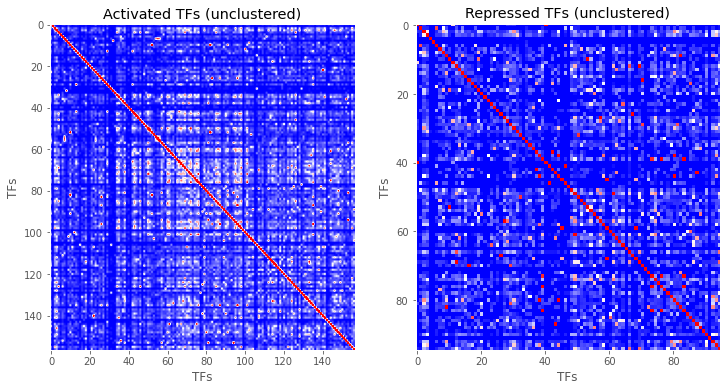

In [31]:
#Generate pairwise matrix of Jaccard distance between TFs in network, using activated TFs
jaccard_matrix_act = dict_to_jaccard(coverage_dict_act)
print("Jaccard activators")
print(jaccard_matrix_act.iloc[0:5,0:3],"\n")
 
#Generate pairwise matrix of Jaccard distance between TFs in network, using repressed TFs
print("Jaccard repressors")
jaccard_matrix_rep = dict_to_jaccard(coverage_dict_rep)
print(jaccard_matrix_act.iloc[0:5,0:3])

#Plot Jaccard matrices
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(12)

#Activated TFs subplot
ax1.imshow(jaccard_matrix_act,aspect="auto",cmap="bwr",vmin=0,vmax=0.5)
ax1.grid(False)
ax1.set_ylabel("TFs")
ax1.set_xlabel("TFs")
ax1.set_title("Activated TFs (unclustered)")

#Repressed TFs subplot
ax2.imshow(jaccard_matrix_rep,aspect="auto",cmap="bwr",vmin=0,vmax=0.5)
ax2.grid(False)
ax2.set_ylabel("TFs")
ax2.set_xlabel("TFs")
ax2.set_title("Repressed TFs (unclustered)")

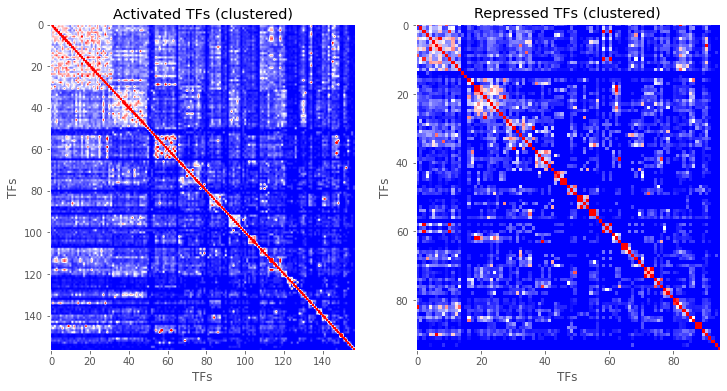

In [32]:
#Binarize and cluster Jaccard matrices
unmix_act = cluster_distance_matrix(jaccard_matrix_act)
unmix_rep = cluster_distance_matrix(jaccard_matrix_rep)

#Plot Jaccard matrices
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(12)

#Activated TFs subplot
ax1.imshow(jaccard_matrix_act.loc[np.hstack(unmix_act),np.hstack(unmix_act)],
           aspect="auto",cmap="bwr",vmin=0,vmax=0.5)
ax1.grid(False)
ax1.set_ylabel("TFs")
ax1.set_xlabel("TFs")
ax1.set_title("Activated TFs (clustered)")

#Repressed TFs subplot
ax2.imshow(jaccard_matrix_rep.loc[np.hstack(unmix_rep),np.hstack(unmix_rep)],
           aspect="auto",cmap="bwr",vmin=0,vmax=0.5)
ax2.grid(False)
ax2.set_ylabel("TFs")
ax2.set_xlabel("TFs")
ax2.set_title("Repressed TFs (clustered)")

#Save figure to file
plt.savefig(os.path.join(tf_network_directory,"clustered_tf_jaccard_matrices.pdf"),bbox_inches="tight")

## Infer master regulators

In [33]:
def infer_master_regulators(coverage_dict, network_degrees, unmix_tst):
    #Select TF with greatest coverage from each cluster     
    max_coverage_tfs = select_optimal_tfs(unmix_tst,coverage_dict)
    
    #Order selected TFs by out/in-degree ratio (highest ratio of direct targets)
    tmp_list=[]
    for tf in max_coverage_tfs:
        if len(np.where(network_degrees.Alt_ID==tf)[0])>0:
            tmp_list.append(network_degrees.index[np.where(network_degrees.Alt_ID==tf)[0]][0])
    #print(tmp_list)
    selected_regulator_degrees = network_degrees.loc[tmp_list,:]
    selected_regulator_degrees.dropna(inplace=True)
    selected_regulator_degrees.sort_values(by="out/in",ascending=False,inplace=True)
    #print(selected_regulator_degrees)

    #Optimize proprtion of network recovered for the smallest number of TFs.
    #Use cut-off of at least 5% coverage increase to include TF.
    mapped_regs = []
    network_coverage = []
    for i in range(selected_regulator_degrees.shape[0]):
        tmp_regs = coverage_dict[selected_regulator_degrees.iloc[i,0]]
        mapped_regs = union(mapped_regs,tmp_regs)
        network_coverage.append(len(mapped_regs)/float(network_degrees.shape[0]))

    #Apply cutoff for calling regulator "master regulator"
    tol = 0.05 #0.05 means don't count regulator if it contributes < 5%
    diff_ = np.diff(network_coverage)
    cut = len(diff_)
    for j in range(len(diff_)):
        if diff_[j]<tol:
            cut=j
            break
    #print(diff_)
    #Select master regulators
    master_regulator_list = list(selected_regulator_degrees.index[0:cut+1])
    print("Master regulators:",master_regulator_list)

    #Make dictionary of master regulators and downstream targets
    master_regulator_dict = {tf:coverage_dict[network_degrees.loc[tf,"Alt_ID"]] for tf in master_regulator_list}
    
    return master_regulator_list, master_regulator_dict, selected_regulator_degrees

def select_optimal_tfs(unmix_tst,coverage_dict):
    import numpy as np
    max_coverage_tfs = []
    for l in unmix_tst:
        maxcov_tf = [len(coverage_dict[tf]) for tf in l]
        max_tf = np.array(l)[np.argmax(maxcov_tf)]
        max_coverage_tfs.append(max_tf)
    return max_coverage_tfs

def master_partners(master_regulator_list,tf_network):
    loops = []
    for mstr in master_regulator_list:
        tmp_sources = list(tf_network[tf_network.Target==mstr].Source)
        tmp_targets = list(tf_network[tf_network.Source==mstr].Target)
        pot_hits = list(set(tmp_sources)&set(tmp_targets))

        if len(pot_hits) > 0:
            for hit in pot_hits:
                tmp_df1 = tf_network[tf_network.Target==mstr]
                tmp_df1.index = tmp_df1.Source
                tmp_hit_mstr_edge = float(tmp_df1.loc[hit,"Edge"])

                tmp_df2 = tf_network[tf_network.Source==mstr]
                tmp_df2.index = tmp_df2.Target
                tmp_hit_edge_mstr = float(tmp_df2.loc[hit,"Edge"])

                if tmp_hit_mstr_edge>0:
                    if tmp_hit_edge_mstr>0:
                        loops.append([mstr,hit])
    
    if len(loops) == 0:
        print("No master partners discovered")
        
    elif len(loops) > 0:
        print("Discovered master partners:",loops)

    return loops

In [34]:
#Infer master regulators from the tf:downstream targets dictionary, network degree information, and tf clusters
master_act_list, master_act_dict, selected_acts = infer_master_regulators(coverage_dict_act, network_degrees, unmix_act)
master_rep_list, master_rep_dict, selected_reps = infer_master_regulators(coverage_dict_rep, network_degrees, unmix_rep)

Master regulators: ['IRF2', 'CREB1']
Master regulators: ['ELF3']


In [35]:
selected_acts

,Alt_ID,in_degree,out_degree,out/in
IRF2,ENSG00000168310,7.0,28.0,4.000000
CREB1,ENSG00000118260,5.0,20.0,4.000000
CEBPA,ENSG00000245848,3.0,9.0,3.000000
EGR1,ENSG00000120738,4.0,10.0,2.500000
IRF9,ENSG00000213928,3.0,7.0,2.333333
EP300,ENSG00000100393,4.0,9.0,2.250000
CTCF,ENSG00000102974,5.0,11.0,2.200000
FOXF2,ENSG00000137273,3.0,6.0,2.000000
NFE2L2,ENSG00000116044,8.0,13.0,1.625000
ZNF148,ENSG00000163848,4.0,6.0,1.500000


In [36]:
selected_reps

,Alt_ID,in_degree,out_degree,out/in
ELF3,ENSG00000163435,2.0,16.0,8.000000
NR0B1,ENSG00000169297,1.0,4.0,4.000000
TBX1,ENSG00000184058,2.0,4.0,2.000000
SOX1,ENSG00000182968,6.0,10.0,1.666667
POU3F1,ENSG00000185668,3.0,5.0,1.666667
SP4,ENSG00000105866,6.0,8.0,1.333333
POU3F3,ENSG00000198914,6.0,8.0,1.333333
HOXD13,ENSG00000128714,2.0,2.0,1.000000
HIC1,ENSG00000177374,5.0,4.0,0.800000
SH2D1A,ENSG00000183918,4.0,3.0,0.750000


In [37]:
#Write shortlist of TFs to file
selected_acts.to_csv(os.path.join(tf_network_directory,"selected_activators.csv"))
selected_reps.to_csv(os.path.join(tf_network_directory,"selected_repressors.csv"))

#Write master regulators to file
master_regulator_df = pd.DataFrame([(";").join(master_act_list),(";").join(master_rep_list)])
master_regulator_df.columns = ["master_regulators"]
master_regulator_df.index = ["activators","repressors"]
master_regulator_df.to_csv(os.path.join(tf_network_directory,"master_regulators.csv"))

#Write master regulators and downstream targets (children + grandchildren) to file
miner.write_json(master_act_dict,os.path.join(tf_network_directory,"master_activators.json"))
miner.write_json(master_rep_dict,os.path.join(tf_network_directory,"master_repressors.json"))

## Investigate tf-tf network for master regulator partners

In [38]:
#If a tf both activates and is activated by a master regulator, it is a partner
master_act_partners = master_partners(master_act_list,tf_network)
master_rep_partners = master_partners(master_rep_list,tf_network)

Discovered master partners: [['IRF2', 'SP100'], ['IRF2', 'STAT5A'], ['IRF2', 'NR3C1'], ['IRF2', 'RELA'], ['IRF2', 'SPI1'], ['CREB1', 'CDC5L'], ['CREB1', 'GABPA']]
Discovered master partners: [['ELF3', 'VDR'], ['ELF3', 'ESR1']]


In [39]:
#Format master partners for inclusion in dataframe
master_pairs_act = [(";").join(p) for p in master_act_partners if len(master_act_partners)>0]
master_pairs_rep = [(";").join(p) for p in master_rep_partners if len(master_rep_partners)>0]

#Write master partners to file
master_pairs = list(np.hstack([master_pairs_act,master_pairs_rep]))
if len(master_pairs)>0:
    master_pairs_df = pd.DataFrame(master_pairs)
    master_pairs_df.columns = ["master_regulator_pair"]
    master_pair_types = pd.DataFrame([np.hstack([["activator" for i in range(len(master_pairs_act))],
                                                ["repressor" for i in range(len(master_pairs_rep))]])]).T
    master_pair_types.columns = ["type"]
    master_pairs_df = pd.concat([master_pair_types,master_pairs_df],axis=1)
    print(master_pairs_df)
    master_pairs_df.to_csv(os.path.join(tf_network_directory,"master_regulator_partners.csv"))

        type master_regulator_pair
0  activator            IRF2;SP100
1  activator           IRF2;STAT5A
2  activator            IRF2;NR3C1
3  activator             IRF2;RELA
4  activator             IRF2;SPI1
5  activator           CREB1;CDC5L
6  activator           CREB1;GABPA
7  repressor              ELF3;VDR
8  repressor             ELF3;ESR1
